<a href="https://colab.research.google.com/github/ArseneGiriteka/PyTorch_Deep_Learning/blob/main/Pythorch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [321]:
What_will_be_covered = {1: "data (prepare and load)",
                        2: "build model",
                        3: "fiting the model to data (training)",
                        4: "making predictions and evaluating model (inference)",
                        5: "saving and reloading model",
                        6: "putting it all together"}

In [322]:
import torch
from torch import nn #nn contains all of pytorch's building blocks for neural networks
import matplotlib.pyplot as plt

torch.__version__

'2.6.0+cu124'

## 1. Data (prepare and loading)
Types of data in machine learning:
* Excel speadsheet
* Image of any kind
* Videos
* Audio
* DNA
* Text

Machine learning is a game of two parts:
1. Get data into numerical representation
2. Build a model to learn patterns in that numerical representation

To showcase this, let's create some kwown data using the linear regression formula.

we'll use a linear regression formula to make a straight line with kwown parameters

In [323]:
# Create *kwown* parameters
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
Y = weight * X + bias
X[:10], Y[:10], len(X), len(Y)

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50,
 50)

### Split data into training and test sets (one of the most important concept in machine learning in general)

Let's Create a training and test set with our data

In [324]:
# Create a train/test split

train_split = int(0.8 * len(X))
X_train, Y_train = X[:train_split], Y[:train_split]
X_test, Y_test = X[train_split:], Y[train_split:]

len(X_train), len(Y_train), len(X_test), len(Y_test)

(40, 40, 10, 10)

### Let's vizualize data

In [325]:
def plot_predictions(train_data=X_train, train_label=Y_train,
                     test_data=X_test, test_label=Y_test,
                     predictions=None):
  """Plots training data, test data and compare predictions."""
  plt.figure(figsize=(10, 7))

  #plot training data in blue
  plt.scatter(train_data, train_label, c="b", s=4, label="Training data")

  #plot test data in green
  plt.scatter(test_data, test_label, c="g", s=4, label="Test data")

  # Are there predictions?
  if predictions is not None:
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14})

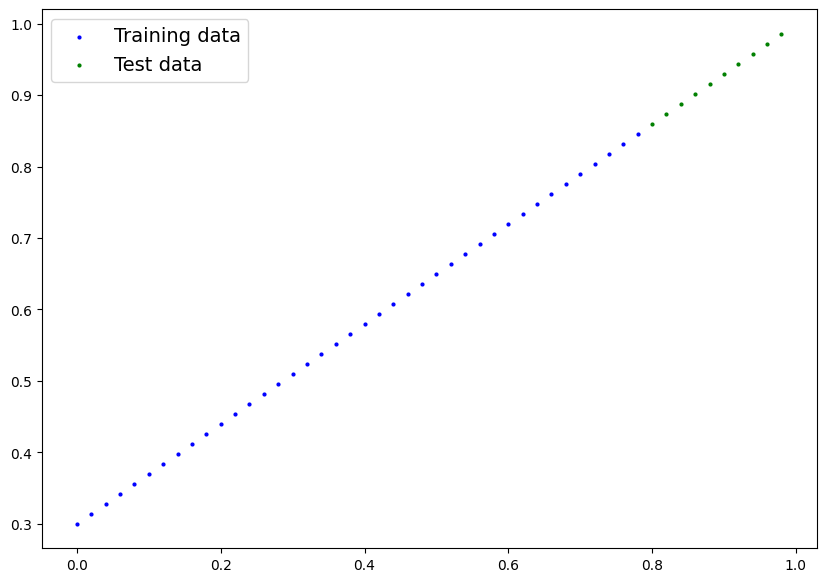

In [326]:
plot_predictions();

## 2. Building a model

first model

What out model does:
* start with random values (weight & bias)
* Look at training data and adjust the random values to better represent (or get closer to) the ideal values (the weight & bias values we used to create the data)

How does it do  so?

Through two main algorithms:
1. Cradient descent
2. Backpropagation

In [327]:
from torch import nn

# Create linear regression model class
class LinearRegressionModel(nn.Module): # <- Almost everything in Pytorch inherits from nn.Module
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))

  # Forward method to define the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data
    return self.weights * x + self.bias # linear regression formula

### Pytorch model building essentials

* torch.nn - contains all of the building for computational graphs (neural networks).
* torch.nn.Parameter - What parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us.
* torch.nn.Module - The base class for all neural network modules, if you subclass it, you should overwrite `forward()`!!!
* torch.optim - this is where the optimizer in PyTorch live, they will help with gradient descent.
* def forward() - All nn.Module subclasses requires you to overwrite `forward()`, this method defines what happens in the forward computation.

### Checking the contents of our PyTorch model

Now we've created a model, let's see what's inside...

So we can check our model parameters or what's inside our model using `.parameter()`.

In [328]:
# Let's create a random seed
torch.manual_seed(42)

# Let's create an instance of the model (this is a subclass of nn.Module)
model_0 = LinearRegressionModel()
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [329]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predictions using `torch.inference_mode()`
To check our model's predictive power, let's see how well it predicts `y_test` based on `x_test`.

When we pass data through our model, it's going to run it through the `forward()` method.

In [330]:
X_test

tensor([[0.8000],
        [0.8200],
        [0.8400],
        [0.8600],
        [0.8800],
        [0.9000],
        [0.9200],
        [0.9400],
        [0.9600],
        [0.9800]])

In [331]:
# Make predictions with model
with torch.inference_mode():
  Y_preds = model_0(X_test)

Y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

You can also do something similar with torch.no_grad(), however, torch.inference_mode() is prefered
```python
with torch.no_grad():
    y_preds = model_0(X_test)
```

In [332]:
Y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

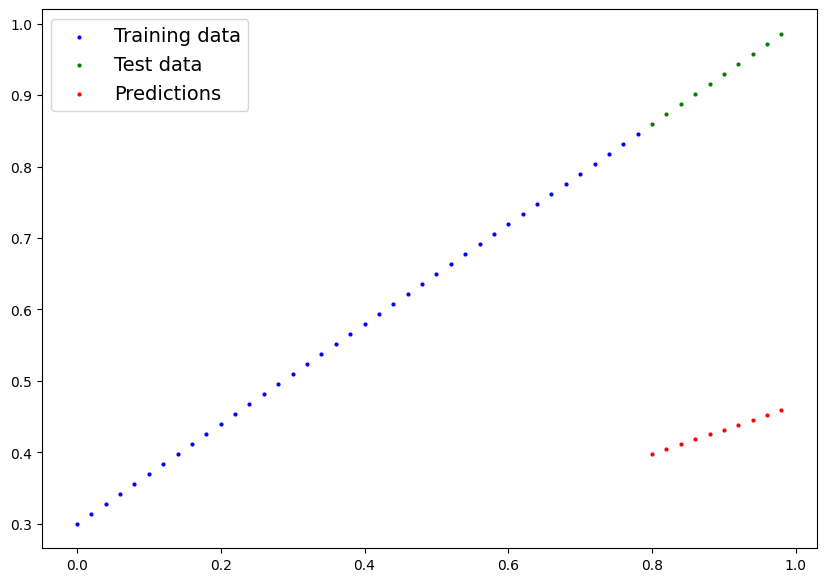

In [333]:
plot_predictions(predictions=Y_preds)

### Training model
The whole idea of training is for a model to move from some unkwown parameters (these may be random) to some known parameters.

Or in other words from a poor representation of the data to a better representation of the data.

* Note: Loss function may also be called cost function or criterion in different areas.


Things we need to train:
* **Losss function:** A function to measure how wrong your model's predictions are to the ideal outputs, Lower is better.
* **Optimizer:** Takes into account the loss of a moddel and adjusts the model's parameters (e.g. weight & bias in our case) to improve the loss function.

  * Inside the optimizer you'll often have to set two parameters:
    * `params` - The model parameter you'd like to optimize, for example `params=model_0.parameters()`.
    * `lr` (learning rate) - the learning is the hyperparameter that defines how big/small the optimizer changes the parameters with each step (a small `lr` results in small changes, a large `lr` results in large changes).


And specifically for PyTorch, we need:

* Training loop
* Testing loop

In [334]:
# setup a loss function
loss_fn = nn.L1Loss()

# setup an optimizer (stocastic gradient descent)
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.001) # lr = learning rate, possibly the most important hyperparameter you can set


### Building a training loop (and a testing loop) in PyTorch

A couple of things we need in a training loop:
0. Loop through the data.
1. Foward pass (this involves data moving through our model's `forward()` functions) to make predictions on data - also called forward propagation.
2. Calculate the loss (compare forward pass predictions to ground truth labels).
3. Optimizer zero grad.
4. Loss backward - move backward through the network to calculate the gradiant of each of the parameters of our model with respect to the loss (**Backpropagation**).
5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss(**Gradient descent**).

In [335]:
# An epoch is one loop through the data... (this is a hyperparameter because we've set it ourselves)
epochs = 2000

epochs_counts = []
loss_values = []
test_loss_values = []

### Training
for epoch in range(epochs):
  # Set the training mode
  model_0.train() # Train mode in PyTorch sets all parameters that require gradients

  # 1. Forward pass
  Y_preds = model_0(X_train)

  # 2. Calculate the loss
  loss = loss_fn(Y_preds, Y_train)

  #3. Optimizer zero grad
  optimizer.zero_grad()

  #4. Perform backpropagation on the loss with respect to the parameters of the model
  loss.backward()

  #5. Step the optimizer (perform gradient descent)
  optimizer.step() # by default how the optimizer changes will accumulate through the loop so... we have to zero them above in step 3 for the netx iteration of the loop



  model_0.eval() # turns off gradient tracking
  # eval() turns off different settings in the model not needed for evaluation/testing (dropout/batch norm layers)

  with torch.inference_mode(): # turns off gradient tracking & a couple more things behind scenes
    # 1. Do the forward pass
    test_pred = model_0(X_test)

    # 2. Calculate the loss
    test_loss = loss_fn(test_pred, Y_test)

  # Print out what's happenning
  if epoch % 10 == 0:
    epochs_counts.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | loss: {loss} | Test loss: {test_loss}")

    # Print out model state_dict()
    print(model_0.state_dict())

Epoch: 0 | loss: 0.31288138031959534 | Test loss: 0.4931890368461609
OrderedDict([('weights', tensor([0.3371])), ('bias', tensor([0.1298]))])
Epoch: 10 | loss: 0.3013603389263153 | Test loss: 0.4797181189060211
OrderedDict([('weights', tensor([0.3410])), ('bias', tensor([0.1398]))])
Epoch: 20 | loss: 0.28983938694000244 | Test loss: 0.4662471413612366
OrderedDict([('weights', tensor([0.3449])), ('bias', tensor([0.1498]))])
Epoch: 30 | loss: 0.2783183455467224 | Test loss: 0.4527761936187744
OrderedDict([('weights', tensor([0.3488])), ('bias', tensor([0.1598]))])
Epoch: 40 | loss: 0.26679736375808716 | Test loss: 0.43930521607398987
OrderedDict([('weights', tensor([0.3527])), ('bias', tensor([0.1698]))])
Epoch: 50 | loss: 0.2552763819694519 | Test loss: 0.4258342385292053
OrderedDict([('weights', tensor([0.3566])), ('bias', tensor([0.1798]))])
Epoch: 60 | loss: 0.24375538527965546 | Test loss: 0.41236335039138794
OrderedDict([('weights', tensor([0.3605])), ('bias', tensor([0.1898]))])
E

In [336]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6994])), ('bias', tensor([0.2998]))])

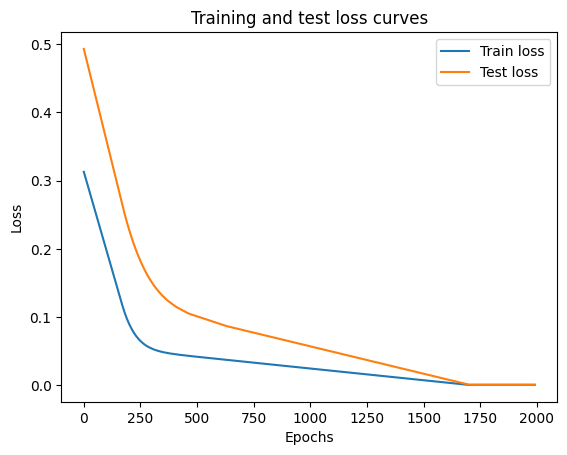

In [337]:
import numpy as np

# Let's visualize loss
plt.plot(epochs_counts, np.array(torch.tensor(loss_values).numpy()), label="Train loss")
plt.plot(epochs_counts, np.array(torch.tensor(test_loss_values).numpy()), label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [338]:
with torch.inference_mode():
  Y_preds_new = model_0(X_test)

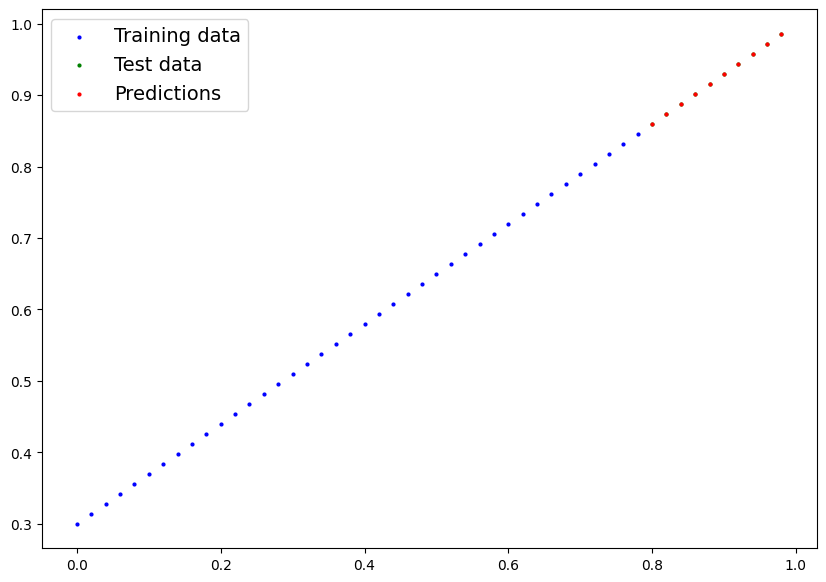

In [339]:
plot_predictions(predictions=Y_preds_new)

## Saving a model in PyTorch

There are three main methods for saving and loading models in PyTorch.

1. `torch.save()` - allows you a PyTorch object in Python's pickle format.
2. `torch.load()` - allows you to load a saved PyTorch object.
3. `torch.nn.Module.load_state_dict()` - this allows you to load a model's saved state dictionary.

In [340]:
# Saving PyTorch model
from pathlib import Path

# 1. Create a models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_0.pt"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dictionary
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_0.pt


## Loading a PyTorch model
Since we save our model's `state_dict()` rather the entire model, we'll create a new instance of our model class and load the saved `state_dict()` into that.

In [341]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6994])), ('bias', tensor([0.2998]))])

In [342]:
# To load in a saved state_dict we have to instantiate a new instance of our model class
loaded_model_0 = LinearRegressionModel()

# Load the saved state_dict of model_0 (this will update the new instance with updated parameters)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6994])), ('bias', tensor([0.2998]))])

In [343]:
# Let's make a couple prediction with the brand new model
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_0_preds = loaded_model_0(X_test)

loaded_model_0_preds

tensor([[0.8593],
        [0.8733],
        [0.8873],
        [0.9013],
        [0.9152],
        [0.9292],
        [0.9432],
        [0.9572],
        [0.9712],
        [0.9852]])

In [344]:
# Let's compare loaded model predictions with original model preds
model_0.eval()
with torch.inference_mode():
  model_0_preds = model_0(X_test)

model_0_preds, loaded_model_0_preds, model_0_preds == loaded_model_0_preds

(tensor([[0.8593],
         [0.8733],
         [0.8873],
         [0.9013],
         [0.9152],
         [0.9292],
         [0.9432],
         [0.9572],
         [0.9712],
         [0.9852]]),
 tensor([[0.8593],
         [0.8733],
         [0.8873],
         [0.9013],
         [0.9152],
         [0.9292],
         [0.9432],
         [0.9572],
         [0.9712],
         [0.9852]]),
 tensor([[True],
         [True],
         [True],
         [True],
         [True],
         [True],
         [True],
         [True],
         [True],
         [True]]))

## 6. Putting it all togethe

In [345]:
import torch
from torch import nn
import matplotlib.pyplot as plt

# Let's check PyThorch version
torch.__version__

'2.6.0+cu124'

Let's create device-agnostic code.

This means if we've got access to a GPU, our code will use it (for potentially faster computing).

If no GPU is available, the code will default to using GPU

In [346]:
# Let's setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


### 6.1 Data

In [347]:
# Let's Create some data using the linear regression formula of y = weight * x + bias
weight = -2
bias = 10

# Let's create a range values
start = -1
end = 1
step = 0.01

# Let's Create X and Y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1) # without unsqueeze, errors will pop up
Y = weight * X + bias
X[:10], Y[:10]

(tensor([[-1.0000],
         [-0.9900],
         [-0.9800],
         [-0.9700],
         [-0.9600],
         [-0.9500],
         [-0.9400],
         [-0.9300],
         [-0.9200],
         [-0.9100]]),
 tensor([[12.0000],
         [11.9800],
         [11.9600],
         [11.9400],
         [11.9200],
         [11.9000],
         [11.8800],
         [11.8600],
         [11.8400],
         [11.8200]]))

In [348]:
# Let's split the data
train_split = int(0.8 * len(X))
X_train, Y_train = X[:train_split], Y[:train_split]
X_test, Y_test = X[train_split:], Y[train_split:]
len(X_train), len(Y_train), len(X_test), len(Y_test)

(160, 160, 40, 40)

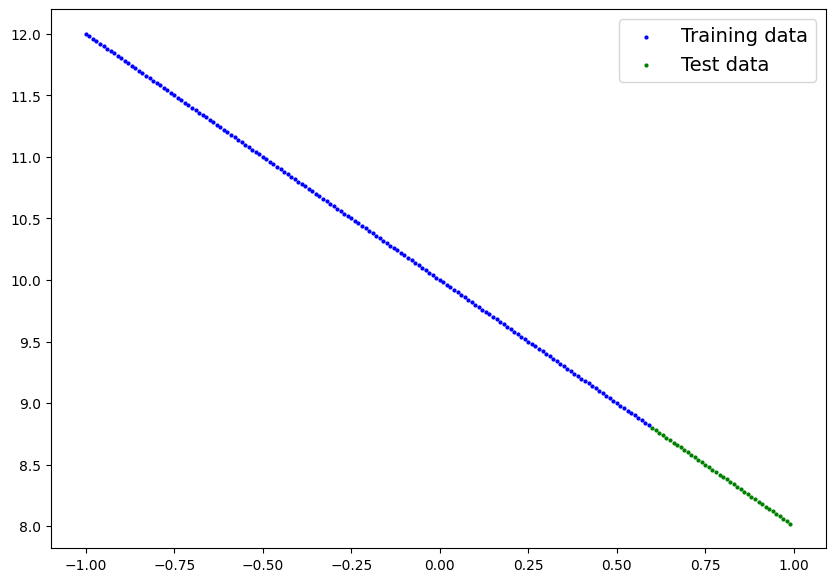

In [349]:
# Plot the data
plot_predictions(X_train, Y_train, X_test, Y_test)

### 6.2 Building a PyTorch Linear model

In [350]:
# Create a linear model by subclassing nn.Module
class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    # Use nn.Linear() for creating the model parameters / also called: linear transform, probing layer, fully connected layer, dense layer
    self.linear_layer = nn.Linear(in_features=1, out_features=1)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

# set the manual seed
torch.manual_seed(24)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.5289]])),
              ('linear_layer.bias', tensor([-0.2499]))]))

In [351]:
# Let's check the model current device
print(next(model_1.parameters()).device)

# Let's set the model device to targeted device
model_1.to(device)
print(next(model_1.parameters()).device)

print(next(model_1.parameters()).device)

# Put data(training and test ) on target device
X_train = X_train.to(device)
X_test = X_test.to(device)
Y_train = Y_train.to(device)
Y_test = Y_test.to(device)

cpu
cuda:0
cuda:0


### 6.3 Training
For training we need:
* Loss function
* Optimizer
* Training loop
* Testing loop

In [352]:
# Put data(training and test ) on cpu device
device = device = "cuda" if torch.cuda.is_available() else "cpu"
X_train = X_train.to(device)
X_test = X_test.to(device)
Y_train = Y_train.to(device)
Y_test = Y_test.to(device)

# Setup loss function
loss_fn = nn.L1Loss() # same as MAE

# Setup our optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.0001)

# Write a training loop
epochs = 130000

for epoch in range(epochs):
  model_1.train()

  # 1. Forward pass
  Y_pred = model_1(X_train)

  # 2. Calculate the loss
  loss = loss_fn(Y_pred, Y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    test_pred = model_1(X_test)
    test_loss = loss_fn(test_pred, Y_test)

  # Print out what's happening

  if epoch % 10 == 0:
    print(f"Epoch {epoch} | Loss: {loss} | Test loss: {test_loss}")

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Epoch 80000 | Loss: 2.4287984371185303 | Test loss: 1.5401076078414917
Epoch 80010 | Loss: 2.427755117416382 | Test loss: 1.5392693281173706
Epoch 80020 | Loss: 2.4267117977142334 | Test loss: 1.53843092918396
Epoch 80030 | Loss: 2.425668478012085 | Test loss: 1.5375925302505493
Epoch 80040 | Loss: 2.4246249198913574 | Test loss: 1.5367542505264282
Epoch 80050 | Loss: 2.423581600189209 | Test loss: 1.535915732383728
Epoch 80060 | Loss: 2.4225380420684814 | Test loss: 1.535077452659607
Epoch 80070 | Loss: 2.421494722366333 | Test loss: 1.5342391729354858
Epoch 80080 | Loss: 2.4204511642456055 | Test loss: 1.5334008932113647
Epoch 80090 | Loss: 2.419407844543457 | Test loss: 1.532562494277954
Epoch 80100 | Loss: 2.4183645248413086 | Test loss: 1.5317240953445435
Epoch 80110 | Loss: 2.41732120513916 | Test loss: 1.5308856964111328
Epoch 80120 | Loss: 2.4162776470184326 | Test loss: 1.5300472974777222
Epoch 80130

In [353]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[-2.0000]], device='cuda:0')),
             ('linear_layer.bias', tensor([10.0000], device='cuda:0'))])

### 6.4 Making and evaluating predictions

In [354]:
model_1.eval()
with torch.inference_mode():
  Y_preds = model_1(X_test)
Y_preds

tensor([[8.8000],
        [8.7800],
        [8.7600],
        [8.7400],
        [8.7200],
        [8.7000],
        [8.6800],
        [8.6600],
        [8.6400],
        [8.6200],
        [8.6000],
        [8.5800],
        [8.5600],
        [8.5400],
        [8.5200],
        [8.5000],
        [8.4800],
        [8.4600],
        [8.4400],
        [8.4200],
        [8.4000],
        [8.3800],
        [8.3600],
        [8.3400],
        [8.3200],
        [8.3000],
        [8.2800],
        [8.2600],
        [8.2400],
        [8.2200],
        [8.2000],
        [8.1800],
        [8.1600],
        [8.1400],
        [8.1200],
        [8.1000],
        [8.0800],
        [8.0600],
        [8.0400],
        [8.0200]], device='cuda:0')

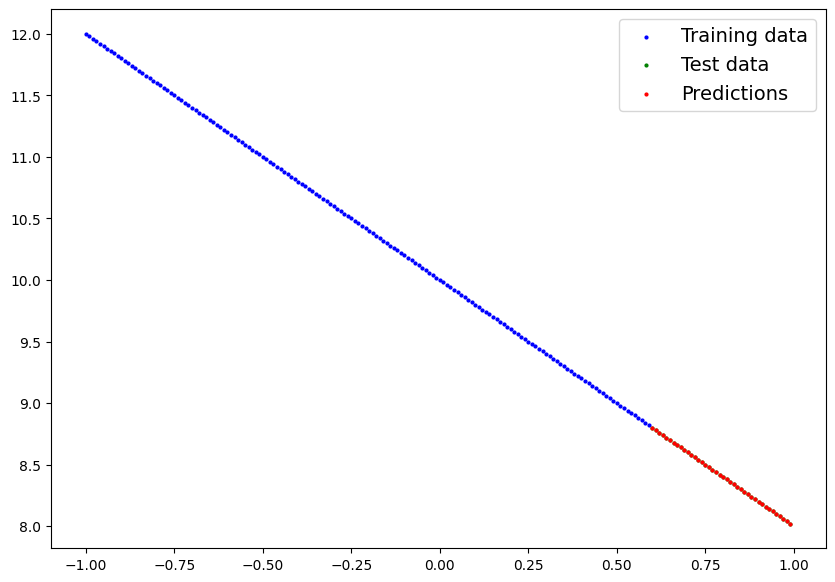

In [355]:
# Put data(training and test ) on cpu device
device = "cpu"
X_train = X_train.to(device)
X_test = X_test.to(device)
Y_train = Y_train.to(device)
Y_test = Y_test.to(device)
Y_preds = Y_preds.to(device)
plot_predictions(train_data=X_train,
                 train_label=Y_train.cpu(),
                 test_data=X_test,
                 test_label=Y_test,
                 predictions=Y_preds)

### 6.5 Save and Loading a trained model

In [356]:
# Saving model_1
from pathlib import Path

MODEL_1_PATH = Path("Models")
MODEL_1_PATH.mkdir(parents=True, exist_ok=True)

MODEL_1_NAME = "pytorch_workflow_1.pt"
MODEL_1_SAVE_PATH = MODEL_1_PATH / MODEL_1_NAME

print(f"Saving {MODEL_1_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), f=MODEL_1_SAVE_PATH)

Saving Models/pytorch_workflow_1.pt


In [357]:
# Loading model_1
loaded_model_1 = LinearRegressionModelV2().to(device)
loaded_model_1.load_state_dict(torch.load(f=MODEL_1_SAVE_PATH))
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[-2.0000]])),
             ('linear_layer.bias', tensor([10.0000]))])